In [0]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

# Fonction objectif du clustering avec données manquantes 


Soit $(X_i)_{i=1...n}$ nos observations de dimension $p$. 
Nous avons aussi la matrice $\Omega$ qui correspond à la donnée disponible (matrice de 0 et 1).

Dans ce contexte de donnée manquante nous allons noté $Y_i= (X_i,\Omega_i)$ le couple de l'observation et de la donnée disponible élement de $\mathbb{R}^p\times \mathbb{N}^p$ . 

Nous définissons l'addition classiquement :
$$(x,\omega)+(y,\omega')=(x+x',\omega+ \omega')$$
et le produit avec un scalaire : 
$$\lambda. (x,\omega)= (\lambda.x,\omega)$$

On prend alors comme semi norme : 
$$N((x,\omega))= \left(\frac{\sum_{i=1}^p \mathbb{1}_{\omega_i>0}x_i^2}{\sum_{i=1}^p \mathbb{1}_{\omega_i>0}}\right)^{1/2}$$

La fonction de moyennisation : Si $y=(x_i,\omega_i)_{i=1...p}$ alors $m(y)=\left(\frac{x_i}{\max(\omega_i,1)},\min(\omega_i,1)\right)_{i=1...p}$ 



Le but est de trouver une $k$-partition de $\{1,...,n\}$ que l'on note $C_1,...,C_k$ telle que l'on minimise la fonction :

$$\phi(C_1,...,C_k)= \sum_{i=1}^k\sum_{j\in C_i}N(Y_j-M_i)$$

où $$M_i=m\left(\sum_{j\in C_i}Y_j\right)$$
Le centroïde du cluster $C_i$

Dans nos données, la valeur de $\omega_i$ sera donnée par le fait de savoir si une variable a la valeur *NaN* ou pas.


In [0]:
def centroide (X,Omega):
    """retourne le centroide de X filtré par Omega """
    Omegap= Omega.sum(axis=0)
    D= np.array([1/max(1,c)for c in Omegap])
    return (D*np.sum(X,axis=0),Omegap)

def norme2(Y):
    """Semi norme 2 d'une variable filtré """
    (X,Omega)=Y
    return np.sqrt(np.sum(Omega*X*X)/np.sum(Omega))

def distance(Y,Yp):
    """Semi distance """
    X,Omega=Y
    Xp,Omegap=Yp
    Z= X-Xp
    Om= Omega+Omegap -Omega*Omegap
    return norme2((Z,Om))
    

def energie(X,Omega):
    """retourne l'énergie d'un cluster """
    M=centroide(X,Omega)
    N=len(X)
    return sum([distance((X[i],Omega[i]),M) for i in range(N)])
    

def phi(C,X,Omega):
    """retourne la somme des energie de chaque cluster """
    k= np.max(C)+1
    return sum([energie(X[C==i],Omega[C==i]) for i in range(k)])

## Heuristique classique 

On va faire l'algorithme classique des k_means comme si on avait la donnée complete, mais en utilisant notre semi norme et notre moyenne 

In [0]:
def centroidePlusProche(Y,M):
    k=len(M)
    return np.argmin([distance(Y,M[i]) for i in range(k)])

In [0]:
def k_means_donnée_manquantes (X,Omega,k,iter_max):
    """heuristique des k-means avec donnée manquante"""
    n=len(X)
    p=len(X[0])
    M=[0 for i in range(k)]
    C=np.random.randint(k, size=n)
    E=[]
    
    for N in range(iter_max):
        # calcul des centroide
        for j in range(k):
            M[j]= centroide(X[C==j],Omega[C==j])
        # Calcul des nouveaux cluster 
        for i in range(n):
            Y= (X[i],Omega[i])
            C[i]= centroidePlusProche(Y,M)
        E.append( phi(C,X,Omega)) 
    return (C,E)

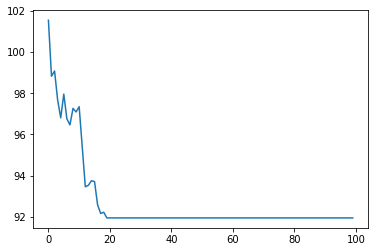

In [0]:
# test sur un echantillon genéré aleatoirement 
n= 100
p=300

X= np.random.normal(size=(n,p))
Omega= np.random.randint(2,size=(n,p))  # la moitié des donnée disponible dans ce test 
C,E= k_means_donnée_manquantes (X,Omega,10,100)
plt.plot(E) # graphe de phi en fonction du nombre d'itération 
plt.show()

## Utilisation des données de la BDF


In [0]:
df= pd.read_csv('dBFin.csv',sep=';')
#df.describe()
import datetime
df['date']=pd.to_datetime(df.Date)
df.sort_values(by=['date'],inplace=True)
df
date = df['Date']
del df['Date']
del df['date']
df.describe()

,crédits/dépôts,cours/valeur banques,rentabilité capitaux propres,rentabilité actifs,actifs bancaires consolidés,actifs des GSIB,inflation,Balance budgétaire Fr,Solde des transactions courantes Fr,CAC total return index,Eurostoxx total return index,CAC index,Eurostoxx Index,CAC financier,CAC biens consommation,CAC pétrole/gaz,Levier bancaire
count,12.000000,14.000000,13.000000,13.000000,1.000000e+01,14.000000,233.000000,19.000000,19.000000,221.000000,221.000000,221.000000,221.000000,233.000000,233.000000,233.000000,10.000000
mean,1.188390,93.675396,0.068762,0.302778,1.010523e+06,0.809225,1.585837,-3.652632,-0.211579,8567.558462,916.817873,4304.000588,3145.527330,772.454163,1367.767725,824.254249,4.183598
std,0.077531,49.141936,0.031939,0.120707,4.829340e+04,0.015929,0.885864,1.552549,0.897040,2619.201992,243.194919,818.677368,582.487975,212.410551,641.330122,123.852426,0.509209
min,1.092967,42.287482,0.025887,0.122833,9.398385e+05,0.777312,-0.800000,-7.200000,-1.690000,4060.710000,457.190000,2692.490000,1993.930000,375.390000,573.990000,550.290000,3.463860
25%,1.127493,67.371091,0.053639,0.214270,9.691203e+05,0.808396,1.000000,-4.100000,-0.675000,6554.430000,721.420000,3678.150000,2715.300000,653.700000,896.920000,744.790000,3.759638
50%,1.170685,75.998972,0.062287,0.333584,1.010786e+06,0.815300,1.700000,-3.500000,-0.510000,8015.930000,872.140000,4293.920000,3066.260000,751.620000,1155.900000,805.210000,4.163661
75%,1.261123,98.106172,0.068141,0.357590,1.044076e+06,0.818391,2.200000,-2.650000,0.125000,10163.340000,1094.040000,5000.730000,3527.830000,864.790000,1604.340000,889.630000,4.630793
max,1.292770,193.549032,0.157807,0.604625,1.083549e+06,0.829353,4.000000,-1.500000,1.710000,14559.320000,1390.280000,6053.900000,4727.710000,1422.460000,3216.430000,1170.210000,4.834006


In [0]:
from sklearn import preprocessing
M=np.array(df)
M = preprocessing.scale(M)

M.shape

(240, 17)

In [0]:
# on calcul le filtre Omega, on enleve les Nan on les remplace par une valeur 
#quelconque qui ne sera jamais dans tous les cas jamais observée
n,p= M.shape
Omega= np.zeros((n,p))
M2=M.copy()
for i in range (n):
  for j in range (p):
    if np.isnan(M[i,j]):
      M2[i,j]=0 #on enleve la NaN pour evité des bugs
    else:
      Omega[i,j]=1



In [0]:
c=np.inf
CM=np.zeros(240)
for i in range(20):
  C,E= k_means_donnée_manquantes (M2,Omega,9,10)
  e=E.pop()
  if e<c:
    c=e
    CM=C

print(len(CM))

print(CM)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


240
[5 5 5 5 5 5 5 5 5 5 5 5 0 5 5 5 5 5 5 5 5 5 5 5 0 5 5 5 5 5 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 6
 6 6 6 5 6 6 6 6 6 6 3 6 6 6 6 6 6 6 6 6 6 6 7 5 5 5 7 5 5 5 5 5 1 1 4 1 1
 5 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 1 1 1 1 1 4 5 5 1
 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2
 2 2 2 5 2 2 2 2 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2 2 8 2 2 2 8 8
 8 8 8 8 2 2 2 2 2 2 2 5 5 5 5 5 5 5]


In [0]:
import plotly.graph_objects as go
df['cluster']=CM
df['date']=date
data= df

print( list(df['date'].to_string()))
fig = go.Figure(data=go.Scatter(x= date,
                                y=data['cluster'],
                                mode='markers',
                                marker_color=data['cluster'],
                                text=pd.to_datetime(df['date']))) # hover text goes here

fig.update_layout(title='Cluster dans le temps')
fig.show()

['0', ' ', ' ', ' ', ' ', ' ', ' ', '0', '1', '/', '0', '1', '/', '2', '0', '0', '0', '\n', '8', '0', ' ', ' ', ' ', ' ', ' ', '0', '1', '/', '0', '2', '/', '2', '0', '0', '0', '\n', '1', '0', '0', ' ', ' ', ' ', ' ', '0', '1', '/', '0', '3', '/', '2', '0', '0', '0', '\n', '2', '0', ' ', ' ', ' ', ' ', ' ', '0', '1', '/', '0', '4', '/', '2', '0', '0', '0', '\n', '1', '2', '0', ' ', ' ', ' ', ' ', '0', '1', '/', '0', '5', '/', '2', '0', '0', '0', '\n', '1', '4', '0', ' ', ' ', ' ', ' ', '0', '1', '/', '0', '6', '/', '2', '0', '0', '0', '\n', '4', '0', ' ', ' ', ' ', ' ', ' ', '0', '1', '/', '0', '7', '/', '2', '0', '0', '0', '\n', '1', '6', '0', ' ', ' ', ' ', ' ', '0', '1', '/', '0', '8', '/', '2', '0', '0', '0', '\n', '1', '8', '0', ' ', ' ', ' ', ' ', '0', '1', '/', '0', '9', '/', '2', '0', '0', '0', '\n', '6', '0', ' ', ' ', ' ', ' ', ' ', '0', '1', '/', '1', '0', '/', '2', '0', '0', '0', '\n', '2', '0', '0', ' ', ' ', ' ', ' ', '0', '1', '/', '1', '1', '/', '2', '0', '0', '0', '\n'

Index(['crédits/dépôts', 'cours/valeur banques',
       'rentabilité capitaux propres', 'rentabilité actifs',
       'actifs bancaires consolidés', 'actifs des GSIB', 'inflation',
       'Balance budgétaire Fr', 'Solde des transactions courantes Fr',
       'CAC total return index', 'Eurostoxx total return index', 'CAC index',
       'Eurostoxx Index', 'CAC financier', 'CAC biens consommation',
       'CAC pétrole/gaz', 'Levier bancaire', 'cluster', 'date'],
      dtype='object')


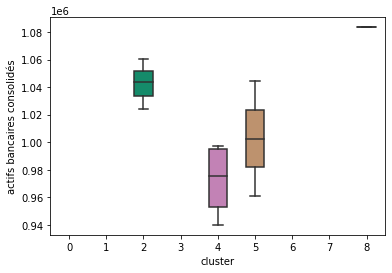

In [0]:

print(df.columns)
import seaborn as sns
bplot = sns.boxplot(y='actifs bancaires consolidés', x='cluster', 
                 data=df, 
                 width=0.5,
                 palette="colorblind")




Index(['crédits/dépôts', 'cours/valeur banques',
       'rentabilité capitaux propres', 'rentabilité actifs',
       'actifs bancaires consolidés', 'actifs des GSIB', 'inflation',
       'Balance budgétaire Fr', 'Solde des transactions courantes Fr',
       'CAC total return index', 'Eurostoxx total return index', 'CAC index',
       'Eurostoxx Index', 'CAC financier', 'CAC biens consommation',
       'CAC pétrole/gaz', 'Levier bancaire', 'cluster', 'date'],
      dtype='object')


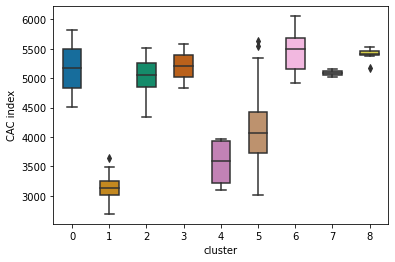

In [0]:
print(df.columns)
import seaborn as sns
bplot = sns.boxplot(y='CAC index', x='cluster', 
                 data=df, 
                 width=0.5,
                 palette="colorblind")

Index(['crédits/dépôts', 'cours/valeur banques',
       'rentabilité capitaux propres', 'rentabilité actifs',
       'actifs bancaires consolidés', 'actifs des GSIB', 'inflation',
       'Balance budgétaire Fr', 'Solde des transactions courantes Fr',
       'CAC total return index', 'Eurostoxx total return index', 'CAC index',
       'Eurostoxx Index', 'CAC financier', 'CAC biens consommation',
       'CAC pétrole/gaz', 'Levier bancaire', 'cluster', 'date'],
      dtype='object')


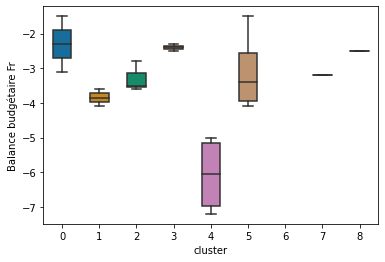

In [0]:
print(df.columns)
import seaborn as sns
bplot = sns.boxplot(y='Balance budgétaire Fr', x='cluster', 
                 data=df, 
                 width=0.5,
                 palette="colorblind")